In [6]:
from model.MultiBranchModel import MultiBranchModel
from model.LSTMModel import LSTMModel
from model.GRUModel import GRUModel 
from helpers.Trainer import Trainer
from helpers.Tester import Tester
from helpers.YoutubeDataset import YoutubeDataset
from helpers.EarlyStopping import EarlyStopping
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


# Load data

In [7]:
train_data = pd.read_csv('data/train_data.csv')
val_data = pd.read_csv('data/val_data.csv')
test_data = pd.read_csv('data/test_data.csv')
train_data.head()

,ytvideoid,views,comments,likes,dislikes,timestamp
0,1,472549,3887,72559,1339,2019-11-25 17:30:00
1,1,472549,4026,74427,1365,2019-11-25 18:00:00
2,1,472549,4150,76092,1388,2019-11-25 18:30:00
3,1,485143,4235,77472,1420,2019-11-25 19:00:00
4,1,532254,4334,78655,1443,2019-11-25 19:30:00


In [8]:
feature_cols = ['views', 'comments', 'likes', 'dislikes'] 

scaler = StandardScaler()

scaler.fit(train_data[feature_cols])

train_scaled = train_data.copy()
train_scaled[feature_cols] = scaler.transform(train_data[feature_cols])

val_scaled = val_data.copy()
val_scaled[feature_cols] = scaler.transform(val_data[feature_cols])

test_scaled = test_data.copy()
test_scaled[feature_cols] = scaler.transform(test_data[feature_cols])

train_scaled.head()

,ytvideoid,views,comments,likes,dislikes,timestamp
0,1,-0.405903,-0.157636,-0.160458,-0.040363,2019-11-25 17:30:00
1,1,-0.405903,-0.154329,-0.153561,-0.040076,2019-11-25 18:00:00
2,1,-0.405903,-0.151378,-0.147413,-0.039823,2019-11-25 18:30:00
3,1,-0.403192,-0.149355,-0.142317,-0.039470,2019-11-25 19:00:00
4,1,-0.393049,-0.146999,-0.137949,-0.039217,2019-11-25 19:30:00


In [9]:
def create_loaders(datasets_scaled: dict[str, pd.DataFrame], 
                    feature_cols: list[str], 
                    target: str, 
                    seq_len: int, 
                    forecast_horizon: int,
                    batch_size: int) -> dict[str, DataLoader]:
    
    res: dict[str, DataLoader] = {}

    for dataset_name, dataset in datasets_scaled.items():
        yt_dataset: YoutubeDataset = YoutubeDataset(
            df=dataset,
            features=feature_cols,
            target=target,
            seq_len=seq_len,
            forecast_horizon=forecast_horizon
        )

        dataloader: DataLoader = DataLoader(
                            yt_dataset,
                            batch_size=batch_size,
                            shuffle= True if dataset_name=='train' else False,
                            drop_last=True,
                            num_workers=6
                        )
        res[dataset_name] = dataloader
        print(yt_dataset.sequences.shape, yt_dataset.targets.shape)
    return res

In [10]:
seq_len = 20
forecast_horizon = 6
batch_size = 128
feature_cols = ['comments', 'likes', 'dislikes'] 

datasets_scaled: dict[str, pd.DataFrame] = {'train': train_scaled,
                                     'val': val_scaled,
                                     'test': test_scaled}

loaders = create_loaders(datasets_scaled=datasets_scaled,
                                                        feature_cols=feature_cols,
                                                        target='views',
                                                        seq_len=seq_len,
                                                        forecast_horizon=forecast_horizon,
                                                        batch_size=batch_size)
train_loader = loaders['train']
val_loader = loaders['val']
test_loader = loaders['test']

torch.Size([886724, 20, 3]) torch.Size([886724, 6])
torch.Size([177206, 20, 3]) torch.Size([177206, 6])
torch.Size([117713, 20, 3]) torch.Size([117713, 6])


# Train

In [20]:
import torch.optim as optim
import torch.nn as nn
import torch

def train(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, model_file_path: str) -> tuple[list[float], list[float]]:

    epochs = 5000
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001) 
    loss_fn = nn.MSELoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'DEVICE: {device.type}')

    early_stopping = EarlyStopping(patience = 30,
                                min_delta = 0.001,
                                verbose = True,
                                path = model_file_path)

    trainer = Trainer(
        model=model,
        optimizer=optimizer,
        loss_fn=loss_fn, 
        device=device,
        early_stopping=early_stopping
    )

    train_loss, val_loss = trainer.fit(train_loader=train_loader, val_loader=val_loader, epochs=epochs)

    return train_loss, val_loss

In [ ]:
multibranch_model = MultiBranchModel(
    input_size=len(feature_cols),
    hidden_size={'lstm': 10, 'gru': 10},
    num_layers={'lstm': 1, 'gru': 1},
    dropout={'lstm': 0, 'gru': 0},
    output_size=forecast_horizon
)
multibranch_train_loss, multibranch_val_loss = train(model=multibranch_model, 
                                                     train_loader=train_loader, 
                                                     val_loader=val_loader,
                                                     model_file_path='models/multibranch_model.pt')

In [ ]:
lstm_model = LSTMModel(
    input_size=len(feature_cols),
    hidden_size=10,
    num_layers=1,
    dropout=0,
    output_size=forecast_horizon
)
lstm_train_loss, lstm_val_loss = train(model=lstm_model, 
                                       train_loader=train_loader, 
                                       val_loader=val_loader,
                                       model_file_path='models/lstm_model.pt')

DEVICE: cpu
Starting training.


Epoch [1/5000] | Training Loss: 0.6561 | Validation Loss: 0.3177
Validation loss improved to 0.3177


Epoch [2/5000] | Training Loss: 0.3943 | Validation Loss: 0.2463
Validation loss improved to 0.2463


Epoch [3/5000] | Training Loss: 0.3410 | Validation Loss: 0.2419
Validation loss improved to 0.2419


Epoch [4/5000] | Training Loss: 0.3250 | Validation Loss: 0.2375
Validation loss improved to 0.2375


Epoch [5/5000] | Training Loss: 0.3154 | Validation Loss: 0.2338
Validation loss improved to 0.2338


Epoch [6/5000] | Training Loss: 0.3075 | Validation Loss: 0.2316
Validation loss improved to 0.2316


Epoch [7/5000] | Training Loss: 0.2888 | Validation Loss: 0.2290
Validation loss improved to 0.2290


Epoch [8/5000] | Training Loss: 0.2758 | Validation Loss: 0.2357
No improvement in validation loss [1/30]


Epoch [9/5000] | Training Loss: 0.2658 | Validation Loss: 0.2254
Validation loss improved to 0.2254


Epoch [10/5000] | Training Loss: 0.2563 | Validation Loss: 0.2366
No improvement in validation loss [1/30]


Epoch [11/5000] | Training Loss: 0.2502 | Validation Loss: 0.2332


Epoch [12/5000] | Training Loss: 0.2456 | Validation Loss: 0.2419


Epoch [13/5000] | Training Loss: 0.2428 | Validation Loss: 0.2402


Epoch [14/5000] | Training Loss: 0.2402 | Validation Loss: 0.2488
No improvement in validation loss [5/30]


Epoch [15/5000] | Training Loss: 0.2378 | Validation Loss: 0.2461


Epoch [16/5000] | Training Loss: 0.2362 | Validation Loss: 0.2440


Epoch [17/5000] | Training Loss: 0.2340 | Validation Loss: 0.2521


Epoch [18/5000] | Training Loss: 0.2322 | Validation Loss: 0.2536


Epoch [19/5000] | Training Loss: 0.2312 | Validation Loss: 0.2542
No improvement in validation loss [10/30]


Epoch [20/5000] | Training Loss: 0.2299 | Validation Loss: 0.2514


Epoch [21/5000] | Training Loss: 0.2286 | Validation Loss: 0.2585


Epoch [22/5000] | Training Loss: 0.2277 | Validation Loss: 0.2505


Epoch [23/5000] | Training Loss: 0.2267 | Validation Loss: 0.2573


Epoch [24/5000] | Training Loss: 0.2252 | Validation Loss: 0.2605
No improvement in validation loss [15/30]


Epoch [25/5000] | Training Loss: 0.2248 | Validation Loss: 0.2550


Epoch [26/5000] | Training Loss: 0.2241 | Validation Loss: 0.2598


Epoch [27/5000] | Training Loss: 0.2238 | Validation Loss: 0.2607


Epoch [28/5000] | Training Loss: 0.2229 | Validation Loss: 0.2576


Epoch [29/5000] | Training Loss: 0.2221 | Validation Loss: 0.2584
No improvement in validation loss [20/30]


Epoch [30/5000] | Training Loss: 0.2214 | Validation Loss: 0.2648


Epoch [31/5000] | Training Loss: 0.2214 | Validation Loss: 0.2620


Epoch [32/5000] | Training Loss: 0.2203 | Validation Loss: 0.2673


Epoch [33/5000] | Training Loss: 0.2198 | Validation Loss: 0.2655


Epoch [34/5000] | Training Loss: 0.2192 | Validation Loss: 0.2669
No improvement in validation loss [25/30]


Epoch [35/5000] | Training Loss: 0.2181 | Validation Loss: 0.2597


Epoch [36/5000] | Training Loss: 0.2178 | Validation Loss: 0.2615


Epoch [37/5000] | Training Loss: 0.2174 | Validation Loss: 0.2636


Epoch [38/5000] | Training Loss: 0.2164 | Validation Loss: 0.2627


Epoch [39/5000] | Training Loss: 0.2164 | Validation Loss: 0.2608
No improvement in validation loss [30/30]
Early stopping triggered.


In [ ]:
gru_model = GRUModel(
    input_size=len(feature_cols),
    hidden_size=10,
    num_layers=1,
    dropout=0,
    output_size=forecast_horizon
)
gru_train_loss, gru_val_loss = train(model=gru_model, 
                                     train_loader=train_loader, 
                                     val_loader=val_loader,
                                     model_file_path='models/gru_model.pt')

DEVICE: cpu
Starting training.


Epoch [1/5000] | Training Loss: 0.6228 | Validation Loss: 0.3119
Validation loss improved to 0.3119


Epoch [2/5000] | Training Loss: 0.4010 | Validation Loss: 0.2601
Validation loss improved to 0.2601


Epoch [3/5000] | Training Loss: 0.3447 | Validation Loss: 0.2205
Validation loss improved to 0.2205


Epoch [4/5000] | Training Loss: 0.3078 | Validation Loss: 0.2165
Validation loss improved to 0.2165


Epoch [5/5000] | Training Loss: 0.2950 | Validation Loss: 0.2156
No improvement in validation loss [1/30]


Epoch [6/5000] | Training Loss: 0.2866 | Validation Loss: 0.2159


Epoch [7/5000] | Training Loss: 0.2802 | Validation Loss: 0.2180


Epoch [8/5000] | Training Loss: 0.2750 | Validation Loss: 0.2173


Epoch [9/5000] | Training Loss: 0.2700 | Validation Loss: 0.2185
No improvement in validation loss [5/30]


Epoch [10/5000] | Training Loss: 0.2649 | Validation Loss: 0.2201


Epoch [11/5000] | Training Loss: 0.2595 | Validation Loss: 0.2207


Epoch [12/5000] | Training Loss: 0.2546 | Validation Loss: 0.2197


Epoch [13/5000] | Training Loss: 0.2496 | Validation Loss: 0.2230


Epoch [14/5000] | Training Loss: 0.2452 | Validation Loss: 0.2262
No improvement in validation loss [10/30]


Epoch [15/5000] | Training Loss: 0.2410 | Validation Loss: 0.2308


Epoch [16/5000] | Training Loss: 0.2371 | Validation Loss: 0.2323


Epoch [17/5000] | Training Loss: 0.2352 | Validation Loss: 0.2381


Epoch [18/5000] | Training Loss: 0.2333 | Validation Loss: 0.2377


Epoch [19/5000] | Training Loss: 0.2321 | Validation Loss: 0.2425
No improvement in validation loss [15/30]


Epoch [20/5000] | Training Loss: 0.2309 | Validation Loss: 0.2445


Epoch [21/5000] | Training Loss: 0.2302 | Validation Loss: 0.2464


Epoch [22/5000] | Training Loss: 0.2296 | Validation Loss: 0.2459


Epoch [23/5000] | Training Loss: 0.2291 | Validation Loss: 0.2459


Epoch [24/5000] | Training Loss: 0.2284 | Validation Loss: 0.2440
No improvement in validation loss [20/30]


Epoch [25/5000] | Training Loss: 0.2280 | Validation Loss: 0.2439


Epoch [26/5000] | Training Loss: 0.2277 | Validation Loss: 0.2478


Epoch [27/5000] | Training Loss: 0.2274 | Validation Loss: 0.2448


Epoch [28/5000] | Training Loss: 0.2272 | Validation Loss: 0.2476


Epoch [29/5000] | Training Loss: 0.2265 | Validation Loss: 0.2452
No improvement in validation loss [25/30]


Epoch [30/5000] | Training Loss: 0.2263 | Validation Loss: 0.2500


Epoch [31/5000] | Training Loss: 0.2256 | Validation Loss: 0.2460


Epoch [32/5000] | Training Loss: 0.2252 | Validation Loss: 0.2477


Epoch [33/5000] | Training Loss: 0.2249 | Validation Loss: 0.2463


Epoch [34/5000] | Training Loss: 0.2244 | Validation Loss: 0.2473
No improvement in validation loss [30/30]
Early stopping triggered.


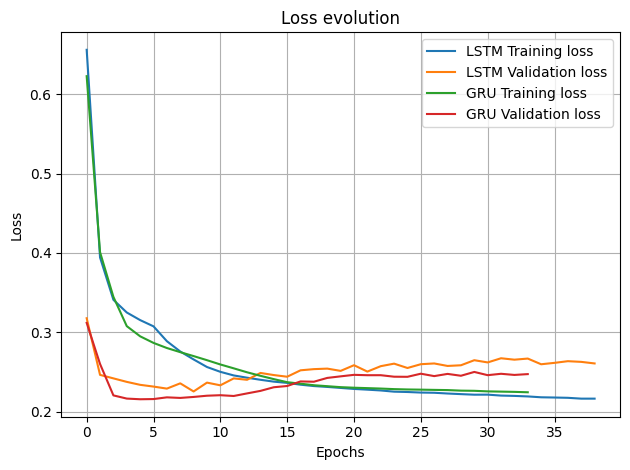

In [17]:
#plt.plot(multibranch_train_loss, label='Multibranch Training loss')
#plt.plot(multibranch_val_loss, label='Multibranch Validation loss')
plt.plot(lstm_train_loss, label='LSTM Training loss')
plt.plot(lstm_val_loss, label='LSTM Validation loss')
plt.plot(gru_train_loss, label='GRU Training loss')
plt.plot(gru_val_loss, label='GRU Validation loss')
plt.title('Loss evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


# Evaluation

In [ ]:
model = MultiBranchModel(
    input_size=len(feature_cols),
    hidden_size={'lstm': 15, 'gru': 15},
    num_layers={'lstm': 1, 'gru': 1},
    dropout={'lstm': 0.3, 'gru': 0.3},
    output_size=forecast_horizon
)
model.load_state_dict(torch.load('best_model.pt', weights_only=False))
tester = Tester(model=model, loss_fn=loss_fn, device=device)
metrics = tester.evaluate(dataloader = test_loader)
metrics

d:\Programacion\Multibranch-TimeSeries-NN\.venv\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


MultiBranchModel(
  (lstm): LSTMLayer(
    (lstm): LSTM(4, 15, batch_first=True, dropout=0.3)
  )
  (gru): GRULayer(
    (gru): GRU(4, 15, batch_first=True, dropout=0.3)
  )
  (linear): Linear(in_features=30, out_features=1, bias=True)
)


{'loss': 0.0007954231333729251,
 'mse': 0.0007955068722367287,
 'mae': 0.004744474310427904,
 'rmse': np.float64(0.02820473138033278),
 'r2': 0.9991093277931213}